Если вы использвуете колаб, загрузите сюда файлы modules.py, utils_pre.py, utils_post.py

In [2]:
import modules

import imp
imp.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
DecoderWithAttention = modules.Decoder
Seq2Seq = modules.Seq2Seq

Здесь я ставлю задачу написать переводчик на основе нейронной сети с испольованием механизма attention. То есть там lstm слой енкодера, attention, слой декодера. Это как бы будет маленькая модель. За большую модель я возьму предобученый BERT. И постараюсь в итоге реализовать knowledge distillation.

В следующей ячейке происходит скачивание примеров предложений на Немецком языке, а также их переводом на английский. Также происходит токенизация, то есть предожения разбиваются на токены, и предложение представляется как набор токенов, то есть предложение это вектор, на опреденном месте стоит число, которое харакеризует токен-слово. Обычно число - номер слова в словаре. Тем самым мы формируем обучающую, валидационную и тестовую выборку.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

! python -m spacy download en
! python -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)


submission_dataset = next(iter(test_iterator))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 1.7MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=7edc00805963b0da2bc1ad231bf34178268e757bc54032c1bb9d6e7ff44f8abb
  Stored in directory: /tmp/pip-ephem-wheel-cache-l7r110pf/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 796kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 231kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 219kB/s]


In [16]:
# Здесь уже происходит формирование модели

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)

dec = DecoderWithAttention(DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS - 1, DEC_DROPOUT)


model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [17]:
# для обучения

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())

PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) # тут вот обычная кроссэнтропия

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
      
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)


            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)


            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output



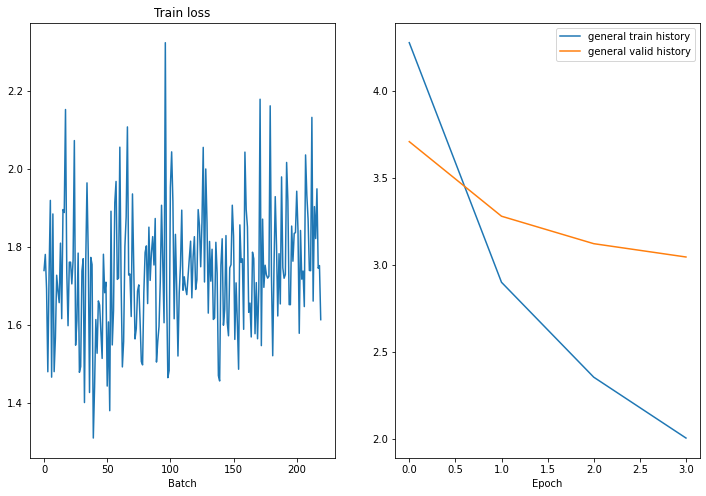

Epoch: 05 | Time: 0m 57s
	Train Loss: 1.737 | Train PPL:   5.682
	 Val. Loss: 3.082 |  Val. PPL:  21.798
| Test Loss: 3.071 | Test PPL:  21.562 |


In [7]:
#Само обучение
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Проверка результата

In [8]:
import utils_pre
import imp
imp.reload(utils_pre)
generate_translation = utils_pre.generate_translation
remove_tech_tokens = utils_pre.remove_tech_tokens
get_text = utils_pre.get_text
flatten = utils_pre.flatten

batch = next(iter(test_iterator))

for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

**Удаляем лишнее первое слово, оно почему то в каждом предложении переводится в начале. И еще удаляем все символы после запятой, для этого используем новый utils.post.py**

In [11]:
import utils_post
import imp
imp.reload(utils_post)
generate_translation = utils_post.generate_translation
remove_tech_tokens = utils_post.remove_tech_tokens
get_text = utils_post.get_text
flatten = utils_post.flatten

In [12]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: four people are playing soccer on a beach
Generated: four people are playing soccer on a beach

Original: a boy riding a skateboard on a skateboarding ramp
Generated: a boy skateboarding skateboarding on a ramp



In [14]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)[1:] # Удаляю первый предсказанный символ
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

8it [00:00, 19.28it/s]


33.04518967950388

Мы видим, что качество метрики bleu достаточно хорошее, 33%. По времени все обучение примерно 12.5 минут

А теперь давайте загрузим большую прежобученную модель BERT, дообучим ее и попробуем обучить маленькую модель с помощью большой.

У меня не хватило времени прописать все и потестить, не успел исправить ошибку и поэтому отправляю ноутбук неоконченным. Идея понятна - мы берем предобученные BERT, дообучаем на нашей выборке, а потом используем новую функцию потерь для обучения маленькой модели на основе большой. 

In [21]:
#!pip install -U --pre tensorflow-gpu


#!pip install hub
import tensorflow as tf
import hub 

print(tf.__version__)

max_seq_length = 128  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

# Вот он сам сой берт, его надо файнтьюнить
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) 

2.3.1


AttributeError: ignored

In [ ]:
#А вот новая функция лосса 

# Кроссэнтропия ответов большой модели и маленькой

def DistillingLoss(output, true_labels, big_model_logit, T, alpha):
    return F.cross_entropy(F.log_softmax(output/T, dim=-1), torch.max(F.softmax(big_model_logit/T, dim=-1), 1).indices.detach()) * (T*T *2.0* alpha) + F.cross_entropy(output, true_labels) * (1.0 - alpha) 

# KL дивергенция ответов большой модели и маленькой

def DistillingLoss_(output, true_labels, big_model_logit, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output/T, dim=-1), F.softmax(big_model_logit/T, dim=-1).detach()) * (T*T * 2.0 * alpha) + F.cross_entropy(output, true_labels) * (1.0 - alpha) 

    